# Multigrid Methods

Multigrid methods are tremendously successful solvers for matrices arising from non-oscillatory PDE problems. The idea is that we consider a problem on different refinement levels and use solutions on coarser levels to improve upon solutions on finer levels. In this notebook we will closely follow the notes on multigrid methods in the book [Iterative Methods for Sparse Linear Systems](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf) by Yousef Saad.

## The model problem

We consider the following model problem

$$
\begin{align}
-u''(x) &= f(x),~x\in [0, 1]\nonumber\\
u(0) = u(1) &= 0\nonumber
\end{align}
$$

We choose $n$ equally spaced points

$$
x_i = i \times h,~i=0,\dots, n+1, h=1/(n+1)
$$

and approximate

$$
-u''(x_i) \approx \frac{-x_{i+1} + 2x_i - x_{i-1}}{h^2}
$$

This gives us the linear system of equations $Ax = b$ with

$$
A = \begin{bmatrix}2    &   -1     &      &      &    \\
                   -1   &   2      &  -1  &      &    \\
                         &  \ddots     &   \ddots  &  \ddots  &     \\
                         &             &   -1      &    2      & -1 \\
                         &             &           &   -1      &  2
     \end{bmatrix},\quad
     b = h^2\begin{bmatrix}f(x_1)\\ f(x_2)\\ \vdots \\ f(x_{n-1}) \\ f(x_n)\end{bmatrix}.
$$


## Eigenvalues and eigenvectors of the model problem

In order to later understand how multigrid works we need to investigate the behaviour of the eigenvalues and eigenvectors of $A$. Let us define $A$ and compute them.

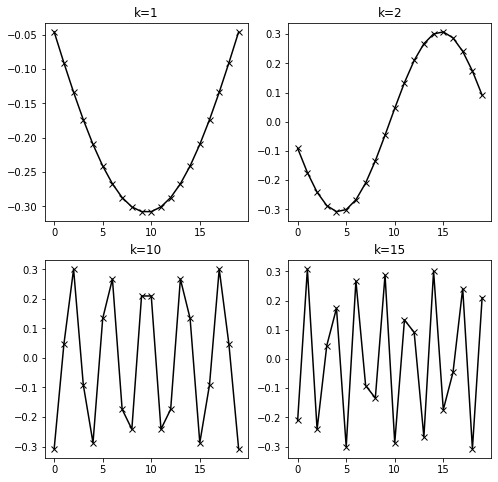

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

n = 20

d1 = 2. * np.ones(n)
d2 = -1. * np.ones(n - 1)

A = np.diag(d1) + np.diag(d2, k=1) + np.diag(d2, k=-1)

lam, V = np.linalg.eigh(A)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(221)
ax.plot(V[:, 0], 'k-x')
ax.set_title('k=1')
ax = fig.add_subplot(222)
ax.plot(V[:, 1], 'k-x')
ax.set_title('k=2')
ax = fig.add_subplot(223)
ax.plot(V[:, 10], 'k-x')
ax.set_title('k=10')
ax = fig.add_subplot(224)
ax.plot(V[:, 15], 'k-x')
ax.set_title('k=15');

One can find an explicit representation of the eigenvalues and eigenvectors for this matrix. It holds that $Av_k = \lambda_k v_k$ with

$$
\lambda_k = 4\sin^2\frac{\theta_k}{2},\quad \theta_k = \frac{k\pi}{n+1},\quad v_k = \sin(k\pi x_i)
$$

## Richardson Iteration

We now introduce a very simple iteration method for the above matrix and try to exactly understand what works and what doesn't with this method. This will give us the right ideas that will lead us to the multigrid iteration.

The Richardson iteration is a very simple iterative method. We start with

$$
b - Ax = 0
$$

Now multiply this equation with a damping factor $\omega$ and add $x$ on both sides of the equation. We obtain the fixed point equation

$$
x = x + \omega(b - Ax).
$$

This motivates the simple fixed point iteration

$$
x_{j+1} = x_j + \omega(b-Ax_j) = (I - \omega A)x_j + \omega b.
$$

This iteration is of the form $x_{j+1} = M_{\omega}x_j + f_{\omega}$ with $M_{\omega} = I-\omega A$ and $f_{\omega} = \omega b$. Let us see under which conditions this iteration converges. The exact solution $x^*$ satisfies $x^* = M_\omega x^* + f_\omega$. Defining the error $e_j = x^* - x_j$ and subtracting equations gives us

$$
e_{j+1} = M_{\omega}e_j = M_\omega^{j+1} e_0.
$$

Let the eigenvalues and eigenvectors of $M_{\omega}$ by denoted by $\mu_i$ and $w_i$. We assume that $M_{\omega}$ is diagonalizable. This implies that we can write

$$
e_0 = \sum_{i}\alpha_iw_i
$$

for some coefficients $\alpha_i$. We hence have that 

$$
e_j = \sum_i \alpha_i \mu_i^{j}w_i.
$$

It follows that the error $e_j$ converges to zero if and only if for all eigenvalues $\mu_i$ we have $|\mu_i| < 1$. For the Richardson method applied to our example problem we have that $\mu_i = 1 - \omega \lambda_i$, where $\lambda_i$ was defined earlier. We obtain the bound

$$
1 - \omega\lambda_n \leq \mu_i \leq 1 - \omega \lambda_1.
$$

We need to choose $\omega$ such that $|\mu_i| < 1$ or equivalently $-1 < \mu_i < 1$. The upper bound is always satisfied if $\omega > 0$ as the above equation shows. For the lower bound we need to choose $\omega$ such that $-1 < 1-\omega\lambda_n$ or equivalently

$$
0 < \omega < \frac{2}{\lambda_n}.
$$

Hence, if $\gamma$ is an upper bound to $\lambda_n$ then the Richardson iteration converges if $\omega = \frac{1}{\gamma}$. For the error reduction in each step of the Richardson iteration applied to our model problem we obtain

$$
e_j = \sum_i\left(1 - \frac{\lambda_i}{\gamma}\right)^j\alpha_iv_i,
$$

where the $v_i$ are the eigenvectors of our matrix $A$ and the $\alpha_i$ are the expansion coefficients of $e_0$ in this basis.

## Applying the Richardson iteration to the model problem

Now remember that the eigenvalues of $A$ are given by $\lambda_j = 4\sin^2\frac{\theta_j}{2}$. An upper bound is therefore immediately obtained as $\lambda_n < 4$. We hence choose $\omega = \frac{1}{4}$. The following code implements the Richardson iteration with this parameter.

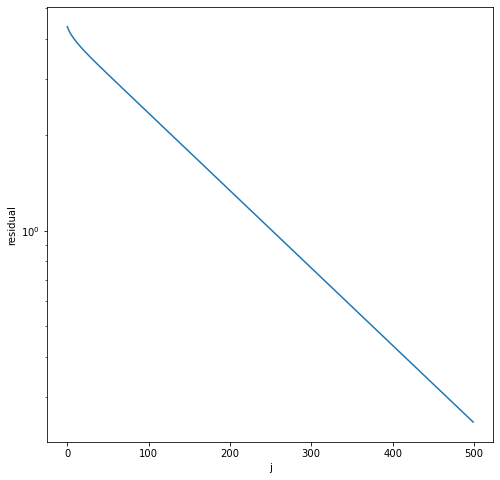

In [56]:
def richardson(A, b, nsteps):
    """Performs n steps of Richardson iteration. Returns residual."""
    
    x = 0
    res = b
    
    residuals = []
    
    for index in range(nsteps):
        x = x + .25 * res
        res = b - A @ x
        residuals.append(np.linalg.norm(res))
        
    return residuals

b = np.ones(n, dtype=np.float64)
    
residuals = richardson(A, b, 500)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(residuals)
ax.set_xlabel('j')
ax.set_ylabel('residual');

The iteration converges but very slowly. What is the reason? Each error component is reduced by the factor $\left(1 - \frac{\lambda_k}{\gamma}\right)$. This means that the error reduction is worst for the smallest eigenvalue. We obtain for $\lambda_1$

$$
(1 - \frac{\lambda_1}{4})^j = 1 - \sin^2\frac{\pi}{2(n+1)}\approx 1 - \left(\frac{\pi h}{2}\right)^2 = 1 - \mathcal{O}(h^2).
$$
As $h$ descreases the rate of convergence becomes arbitrarily slow. However, the highly oscillatory eigenvalues give a rapid error reduction. For eigenvalues with $k>n /2$ we have

$$
1 - \sin^2\frac{k\pi}{2(n+1)}=\cos^2\frac{k\pi}{2(n+1)}\leq \frac{1}{2}.
$$

Hence, the high-frequency errors (those associated with higher oscillatory eigenvectors) are reduced rapidly. The reduction factors behave as follows with respect to the index $k$.

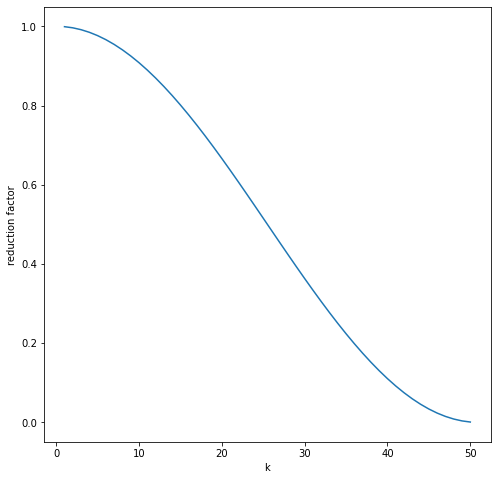

In [57]:

n = 50

krange = np.arange(1, n + 1)
factors = 1 - np.sin(krange * np.pi / (2 * (n + 1)))**2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(krange, factors)
ax.set_xlabel('k')
ax.set_ylabel('reduction factor');

The above plot shows the reduction factors. The ones associated with the smaller $k$ belong to low frequency eigenmodes. The once associated with higher $k$ belong to high frequency eigenmodes. The plot below shows a low oscillatory mode and a high oscillatory mode. We talk about low frequency up until $k\leq n/2$.

Text(0.5, 1.0, 'highly oscillatory mode (k=40)')

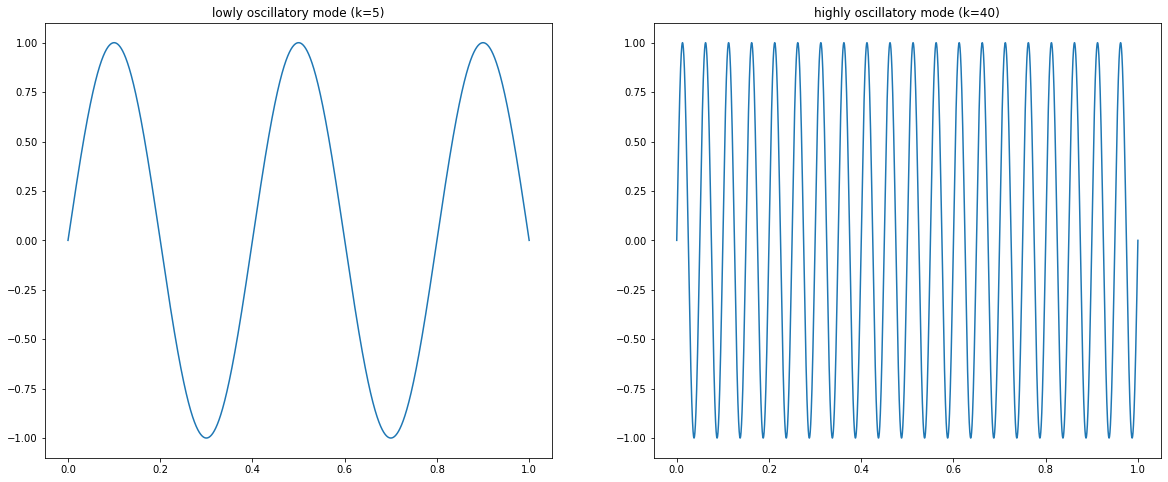

In [46]:
xrange = np.linspace(0, 1, 5000)
low_mode = np.sin(5 * np.pi * xrange)
high_mode = np.sin(40 * np.pi * xrange)
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.plot(xrange, low_mode)
ax1.set_title('lowly frequency mode (k=5)')
ax2 =  fig.add_subplot(122)
ax2.plot(xrange, high_mode)
ax2.set_title('high frequency mode (k=40)')

## Error reduction on the coarse mesh

The multigrid idea is as follows. High-frequency components in the error are rapidly reduced through the Richardson iteration. In order to reduce low-frequency errors we move to a coarser mesh. On a coarser mesh some of the modes that are low-frequency on the original mesh now become high-frequency and are therefore effectively reduced on the coarser mesh. We then need to update our solution on the fine mesh again. We can do almost arbitrary cycles between coarser and finer meshes, recursing several stages down the hierarchy to very coarse meshes and back.

Let's work out this idea. For simplicity we assume that $n$ is odd. by $\Omega_{2h}$ we denote the grid obtained by going from $h$ to $2h$. We have

$$
x_i^{2h} = i(2h) = x_{2i}^h.
$$

So the point $x_i$ on level $2h$ is the same as the point $2i$ on the grid with level $h$. Correspondingly for the eigenmode $v_k$ we have

$$
v_k(x_{2i}^h) = \sin(k\pi x_{2i}^h) = \sin(k\pi x_i^{2h}) = v_k^{2h}(x_i^{2h})
$$

What does this mean? Eigenmodes on the finer level are sampled down to eigenmodes on the coarser level with the same index. Hence, if we have the eigenmode with index $k\approx \frac{n}{2}$ on the finer level, which is on the edge between low and high oscillatory modes, it becomes a high oscillatory mode on the level $2h$ as it is the highest eigenmode here and will hence be effectively reduced. Let us consider the corresponding reduction factors on each level.

On the fine level the reduction factor is $1 - \sin^2\frac{k\pi}{2(n+1)}\approx \frac{1}{2}$ on the fine mode for $k\approx \frac{n}{2}$. However, on the coarser mode the corresponding reduction factor reduces to $1 - \sin^2\frac{n/2 \pi}{2(n/2 + 1)}\approx 0$, leading to a rapid reduction of this error component.

## Moving between the fine mesh and the coarse mesh

To move between the fine mesh and the coarse mesh we define a prolongation and a restriction operator. The prolongation operator $I_{2h}^h$ takes us from $\Omega_{2h}$ (the coarse mesh) to $\Omega_h$ (the fine mesh). Let $v^{h} = I_{2h}^hv^{2h}$ be the map between the vector $v^{2h}$ on the coarse mesh and $v^{h}$ on the fine mesh. We define the entries of $v^{h}$ by

$$
\begin{align}
v_{2j}^h &= v_j^{2h}\nonumber\\
v_{2j+1}^h &= \left(v_j^{2h} + v_{j+1}^{2h}\right)/2\nonumber
\end{align}
$$
Hence, for even $j$ we just transfer the corresponding value onto the fine mesh. For the in-between values we take the average. In matrix form the operator looks like

$$
v^{h} = \frac{1}{2}\begin{bmatrix}1    &    &    &   \\
                                  2    &    &    &   \\
                                  1    &  1 &    &   \\
                                       &  2 &    &   \\
                                       &  1 & 1  &   \\
                                       &    & \vdots & \\
                                       &    & \vdots & \\
                                       &    & 1     &  1 \\
                                       &    &        & 2 \\
                                       &    &       &  1 \end{bmatrix}v^{2h}
$$

The restriction operator $I_h^{2h}$ is defined by 

$$
I_h^{2h}v^{h} = v^{2h}
$$
with $v_j^{2h} = \frac{1}{4}\left(v_{2j-1}^h + 2v_{2j}^h + v_{2j+1}^h\right)$. It follows that

$$
I_{2h}^h = 2(I_h^{2h})^T.
$$

Hence, the restriction factor is up to the factor $2$ just the transpose of the prolongation operator.

## The full multigrid cycle

We now want to solve

$$
A_hu^h = f^h
$$

on the fine grid.

We define a smoothing operation

$$
u_{\nu}^h = \text{smooth}(A_h, u_0^{h}, f_h)
$$

by performing $\nu$ steps of the Richardson iteration. This rapidly reduces the high frequency error components, that's why the name smoothing is chosen. A **two grid cycle** now takes the following form

* Pre-smooth $u^{h} := \text{smooth}^{\nu_1}(A_h, u_0^h, f^{h})$
* Compute the residual $r^{h} = f^{h} - A_hu^{h}$
* Coarsen $r^{2h} = I_h^{2h}r^{h}$
* Solve $A_{2h}\delta^{2h} = r^{2h}$
* Correct $u^{h} := u^{h} + I_{2h}^{h}\delta^{2h}$
* Post-smooth $u^{h} := \text{smooth}^{\nu_2}(A_h, u^{h}, f^{h})$

Instead of solving the system on the coarse grid we can recursively continue and move to a coarser cycle of size $4h$ and so on. There is significant freedom in choosing the parameters and the precise implementation depends on the application context.

We can apply a sequence of multigrid cycles directly as an iterative solver for the system on the finest level. We just repeat the above steps until convergence. Alternatively, we can apply a single (or multiple) multigrid steps as an effective preconditioner for a Krylov subspace solver.

## Algebraic multigrid

The method derived above is called a geometric multigrid method. It requires precise knowledge on the hierarchy of meshes to define the restriction and prolongation operators. These become more complicated in more than one dimension, but can be designed. Especially for regular meshes geometric multigrid methods can be easily implemented. However, for more general problems where we do not easily have a hierarchy of meshes (consider unstructured meshes) the above ideas do not translate easily. Here, one can use so-called **algebraic multigrid methods (AMG)**. These define restriction and prolongation operators directly on the matrix by analysing the matrix elements heuristically to simulate what a geometric multigrid solver might do if mesh information were available.

AMG has itself established as a highly efficient preconditioning tool for non-oscillatory PDE problems (e.g. Poisson type problems). They are available in PETSc and many other solvers and are the preconditioner of choice for many practical applications.

